In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí AR modelu

Cílem cvičení je namodelovat "covidovou" časovou řadu. Použita bude *datová sada obsahující počty potvrzených případů za posledních 7 a 14 dní za celou ČR včetně přepočtu na 100 000 obyvatel.*
- Link na data: https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/incidence-7-14-cr.csv
- Link na popis: https://opendata.mzcr.cz/cs_CZ/dataset/covid-19-prehled-osob-s-prokazanou-nakazou-za-7-a-14-dni-za-cr

(Ne, u datové sady opravdu popisek nenajdete. A k sadě se ani přímočaře nedostanete...)

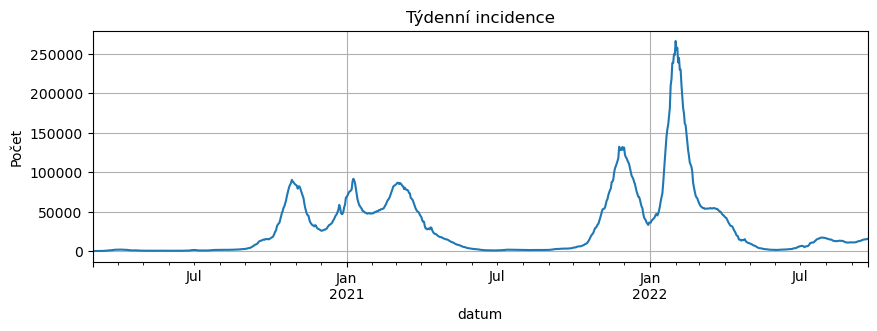

In [3]:
fn = 'incidence-7-14.csv'
data_covid = pd.read_csv(fn, index_col='datum', parse_dates=True)
data_covid = data_covid.asfreq('D')
data_covid['incidence_7'].plot(figsize=(10,3))
plt.title('Týdenní incidence')
plt.ylabel('Počet')
plt.show()

Vybereme si nějakou relativně stabilní situaci, kdy nedochází k rapidní změně trendu. Touto problematikou se budeme totiž zabývat až v příštích týdnech.

Z hlediska pružnosti práce s daty není špatný nápad si datumy držet jako `datetime` instanci.

In [4]:
from datetime import date, timedelta
date_from = '2021-08-01'
date_to = '2021-08-30'
date_from = date.fromisoformat(date_from)
date_to = date.fromisoformat(date_to)

Nyní se podívejme, jak data vypadají:

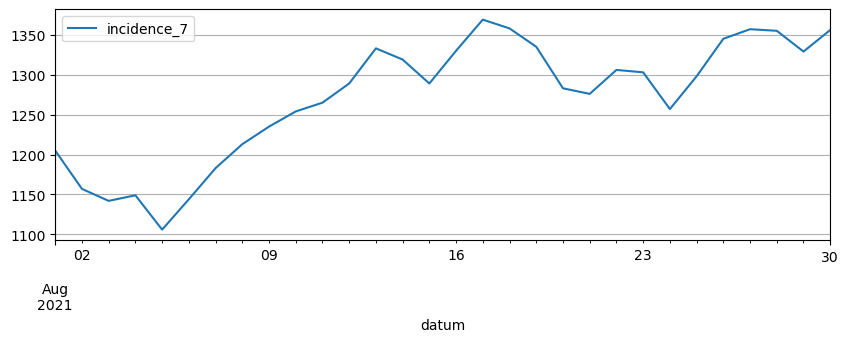

In [5]:
df_orig = data_covid['incidence_7']
df = df_orig.loc[date_from:date_to]
df.plot(figsize=(10,3))
plt.legend()
plt.show()

Zajímat nás bude, jak vypadají ACF a PACF grafy, zdali budou odpovídat alespoň přibližně nějakému AR procesu:

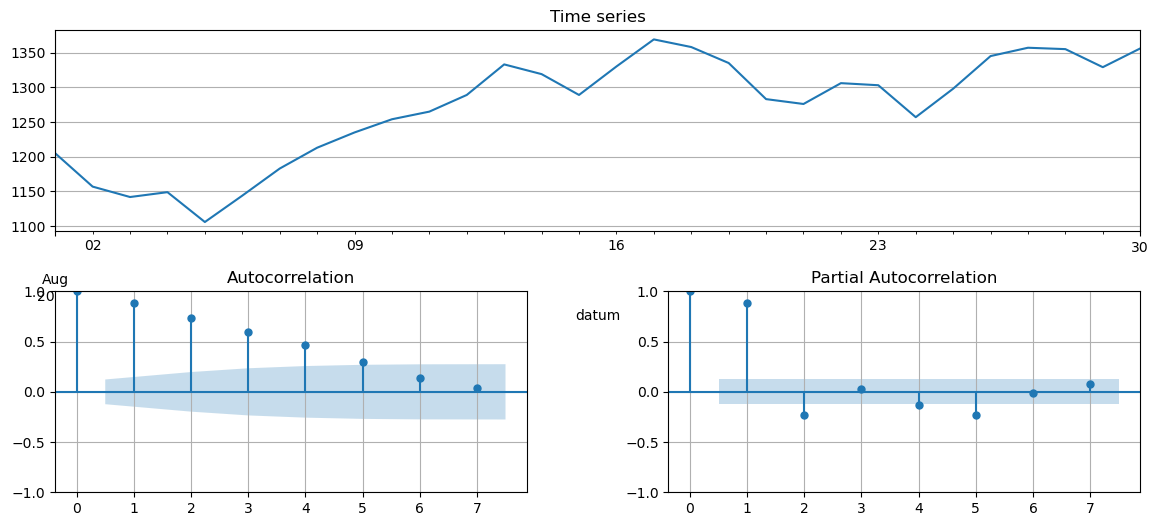

In [6]:
tsplot(df, lags=7)

Zřejmě bychom mohli AR model aspoň zkusit. Budeme se tedy pokoušet o model známý z přednášky ve tvaru

$$
X_t = c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t, \qquad \text{iid.}\ \varepsilon_t \sim \mathrm{N}(0, \sigma^2),
$$

kde $X_t$ reprezentuje modelovanou veličinu, $c$ je offset (posunutí, aditivní konstanta) a $\phi_1, \ldots, \phi_p$ jsou regresní koeficienty.

Podle PACF bychom zkoušeli nejspíš do 2. řádu, podívejme se ještě na automatické hledání řádů pomocí kritérií. Nejčastěji používáme AIC nebo BIC, jejichž hodnotu *minimalizujeme*:

**AIC - [Akaikeho informační kritérium](https://en.wikipedia.org/wiki/Akaike_information_criterion)**

Označme počet odhadovaných parametrů $k$ a maximální hodnotu věrohodnosti při daném modelu $\mathcal{L}$. Potom kritérium je číslo

$$
\mathrm{AIC} = 2k - 2\ln \mathcal{L}.
$$

Kritérium je asymptoticky ekvivalentní ke křížové validaci.

**BIC - [Bayesovské informační kritérium](https://en.wikipedia.org/wiki/Bayesian_information_criterion)**

Označme navíc počet pozorování $n$. Potom kritériem je číslo

$$
\mathrm{BIC} = k \ln(n) - 2\ln \mathcal{L}.
$$

V zásadě je jedno, ke kterému se přikloníme, obě mají své výhody a nevýhody, viz články na příslušných odkazech. Ať už vybíráme podle informačního kritéria nebo jinak, v každém případě platí, že **při srovnatelné kvalitě preferujeme modely jednodušší před komplexnějšími**.

In [7]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
out = ar_select_order(df, maxlag=10, ic='aic', trend='c')
print(f'Vhodné řády: {out.ar_lags}')

Vhodné řády: [1, 2, 3]


Pojďme nyní modely nafitovat pomocí `statsmodels`:

In [8]:
model_ar1 = AutoReg(df, lags=1, trend='c')
res_ar1 = model_ar1.fit()
print(res_ar1.summary())

                            AutoReg Model Results                             
Dep. Variable:            incidence_7   No. Observations:                   30
Model:                     AutoReg(1)   Log Likelihood                -139.866
Method:               Conditional MLE   S.D. of innovations             30.085
Date:                Thu, 05 Oct 2023   AIC                            285.731
Time:                        08:40:50   BIC                            289.833
Sample:                    08-02-2021   HQIC                           287.016
                         - 08-30-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             99.7421     94.698      1.053      0.292     -85.863     285.347
incidence_7.L1     0.9255      0.075     12.418      0.000       0.779       1.072
                                    

**V tabulce můžeme vyčíst:**
- logaritmus likelihoodu (čím větší, tím lepší)
- směrodatnou odchylku chyb (čím menší, tím lepší)
- AIC, BIC, HQIC - menší hodnota značí lepší model
- hodnoty odhadnutých koeficientů, jejich standardní chybu, hodnotu testové statistiky (`z`), p-hodnotu testu hypotézy o nulovosti koeficientu (zajímá nás zejm. nejvyšší koeficient) a interval spolehlivosti (zahrnuje 0?)
- kořeny char. rovnice (jsou vně jednotkové kružnice, tj. je modulus > 1?)

Zkusíme ještě další dva řády a podiskutujeme (na cvičení) o rozdílech mezi modely. Který je lepší a proč.

In [9]:
model_ar2 = AutoReg(df, lags=2, trend='c')
res_ar2 = model_ar2.fit()
print(res_ar2.summary())

                            AutoReg Model Results                             
Dep. Variable:            incidence_7   No. Observations:                   30
Model:                     AutoReg(2)   Log Likelihood                -132.688
Method:               Conditional MLE   S.D. of innovations             27.658
Date:                Thu, 05 Oct 2023   AIC                            273.376
Time:                        08:40:50   BIC                            278.705
Sample:                    08-03-2021   HQIC                           275.005
                         - 08-30-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            154.6451     90.056      1.717      0.086     -21.862     331.152
incidence_7.L1     1.1052      0.173      6.383      0.000       0.766       1.445
incidence_7.L2    -0.2221      0.173

In [10]:
model_ar3 = AutoReg(df, lags=3, trend='c')
res_ar3 = model_ar3.fit()
print(res_ar3.summary())

                            AutoReg Model Results                             
Dep. Variable:            incidence_7   No. Observations:                   30
Model:                     AutoReg(3)   Log Likelihood                -126.928
Method:               Conditional MLE   S.D. of innovations             26.631
Date:                Thu, 05 Oct 2023   AIC                            263.855
Time:                        08:40:50   BIC                            270.335
Sample:                    08-04-2021   HQIC                           265.782
                         - 08-30-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            134.7202     94.159      1.431      0.152     -49.827     319.268
incidence_7.L1     1.1193      0.188      5.969      0.000       0.752       1.487
incidence_7.L2    -0.4847      0.272

Trochu předběhneme v přednáškách. Pohledem na koeficienty zjistíme, že p-hodnota `incidence_7.L3` (neboli $\phi_3$) nás vede k *nezamítnutí* hypotézy $H_0: \phi_3 = 0$ na standardní hladině významnosti. Koeficient není statisticky významně odlišný od nuly a v modelu bychom tento řád měli vynechat (tj. preferovat model o řád nižší).

Vybereme si tedy zřejmě AR(2). Jak si stojí z hlediska reziduí?

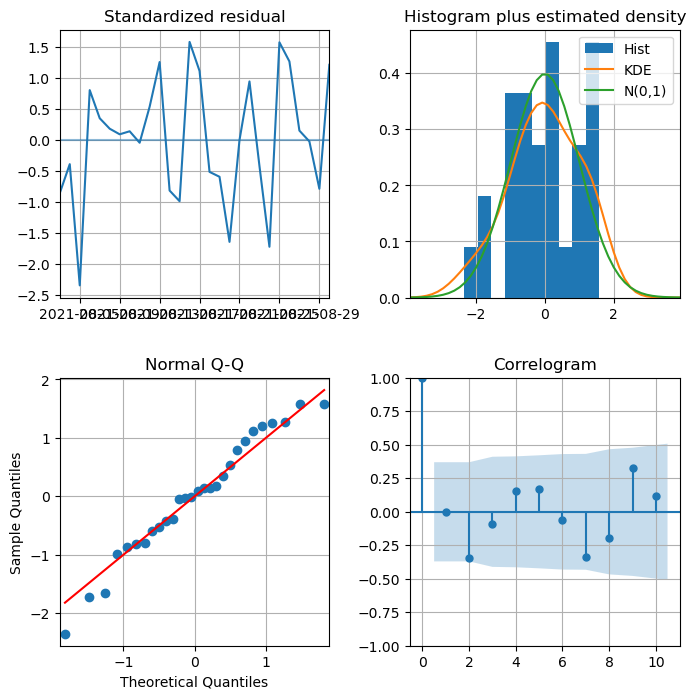

In [11]:
res_ar2.plot_diagnostics(figsize=(8,8))
plt.show()

Grafy nám říkají:
- jaký je průběh reziduí (= časová řada hodnot reziduí) - vidíme nějaké outliery, "systematičnost" apod.?
- histogram a jádrový odhad hustoty (KDE) reziduí - přípomíná KDE přikreslenou "gaussovku"?
- Q-Q plot - leží kvantily reziduí (tečky) na přímce, která by odpovídala kvantilům "gaussovky"?
- korelogram - jsou rezidua vzájemně nekorelovaná?

**Predikce:**

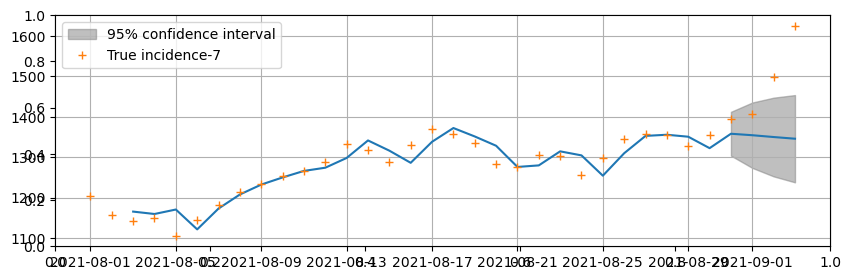

In [31]:
fcast_horizon = 4
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
res_ar2.plot_predict(0, date_to + timedelta(days=fcast_horizon), fig=fig, alpha=0.05)
plt.plot(df_orig.loc[date_from:date_to + timedelta(days=fcast_horizon)],
         '+', label='True incidence-7')
plt.legend()
plt.show()

Proč nemáme predikce pro první dvě měření incidence?

In [27]:
res_ar2.predict(0, date_to + timedelta(days=fcast_horizon))

2021-08-01            NaN
2021-08-02            NaN
2021-08-03    1165.751439
2021-08-04    1159.833030
2021-08-05    1170.900403
2021-08-06    1121.822853
2021-08-07    1173.369017
2021-08-08    1208.032630
2021-08-09    1232.527487
2021-08-10    1250.179482
2021-08-11    1266.292483
2021-08-12    1274.230197
2021-08-13    1298.311913
2021-08-14    1341.610455
2021-08-15    1316.366715
2021-08-16    1286.320088
2021-08-17    1338.294893
2021-08-18    1372.292293
2021-08-19    1351.474470
2021-08-20    1328.497941
2021-08-21    1276.135830
2021-08-22    1279.947203
2021-08-23    1314.657318
2021-08-24    1304.679631
2021-08-25    1254.507227
2021-08-26    1310.035166
2021-08-27    1352.874065
2021-08-28    1355.698983
2021-08-29    1350.823758
2021-08-30    1322.533030
2021-08-31    1358.146929
2021-09-01    1354.523775
2021-09-02    1350.042741
2021-09-03    1345.894956
Freq: D, dtype: float64